In [11]:
# ================================
# IMPORT LIBRARIES AND SETUP
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
import seaborn as sns
import warnings
import os
import pickle
from pykalman import KalmanFilter
from math import radians, sin, cos, atan2, degrees
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler ,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import random

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Set random seeds for reproducibility
np.random.seed(42)

# Create directories for artifacts and visualizations
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
viz_dir = Path('visualization')
viz_dir.mkdir(exist_ok=True)

os.makedirs(artifacts_dir, exist_ok=True)

print("All libraries imported successfully!")
print(f"Artifacts will be saved in: {artifacts_dir}")
print(f"Visualizations will be saved in: {viz_dir}")

All libraries imported successfully!
Artifacts will be saved in: artifacts
Visualizations will be saved in: visualization


In [2]:
# =============================
# DATA ACQUISITION
# ================================

# Load the TON_IoT door sensor dataset
# Note: Replace 'ton_iot_door_sensor.csv' with your actual file path
df = pd.read_csv(r'D:\Skripsi\Train_Test_datasets\Train_Test_IoT_dataset\Train_Test_IoT_GPS_Tracker.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.head(10))
print(f"\nDataset Info:")
print(df.info())
print(f"\nDataset Description:")
print(df.describe())

Dataset loaded successfully!
Dataset shape: (38960, 6)

DATASET OVERVIEW
        date        time    latitude   longitude  label  type
0  25-Apr-19   18:31:39   116.521704  132.162504      1  ddos
1  25-Apr-19   18:31:41   121.742933  135.072500      1  ddos
2  25-Apr-19   18:31:46   121.795929  135.110198      1  ddos
3  25-Apr-19   18:31:49   116.611216  132.224555      1  ddos
4  25-Apr-19   18:31:51   121.841526  135.151362      1  ddos
5  25-Apr-19   18:31:54   116.646869  132.295876      1  ddos
6  25-Apr-19   18:31:59   116.649518  132.419949      1  ddos
7  25-Apr-19   18:32:01   121.920022  135.308132      1  ddos
8  25-Apr-19   18:32:04   116.706300  132.420231      1  ddos
9  25-Apr-19   18:32:06   122.002085  135.325050      1  ddos

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38960 entries, 0 to 38959
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       38960 non-null  object 
 1

Data Types:
date          object
time          object
latitude     float64
longitude    float64
label          int64
type          object
dtype: object

Latitude stats:
count    38960.000000
mean        55.520048
std         75.345705
min          0.000000
25%          2.427997
50%         36.623451
75%         86.592301
max        549.381916
Name: latitude, dtype: float64

Longitude stats:
count    38960.000000
mean        65.849669
std         76.086241
min         10.000000
25%         12.459648
50%         47.244773
75%         96.119494
max        555.133643
Name: longitude, dtype: float64

Unique attack types: ['ddos' 'backdoor' 'injection' 'normal' 'password' 'ransomware' 'scanning'
 'xss']
Attack type distribution:
type
normal        15000
ddos           5000
backdoor       5000
injection      5000
password       5000
ransomware     2833
xss             577
scanning        550
Name: count, dtype: int64

Label distribution:
label
1    23960
0    15000
Name: count, dtype: int64


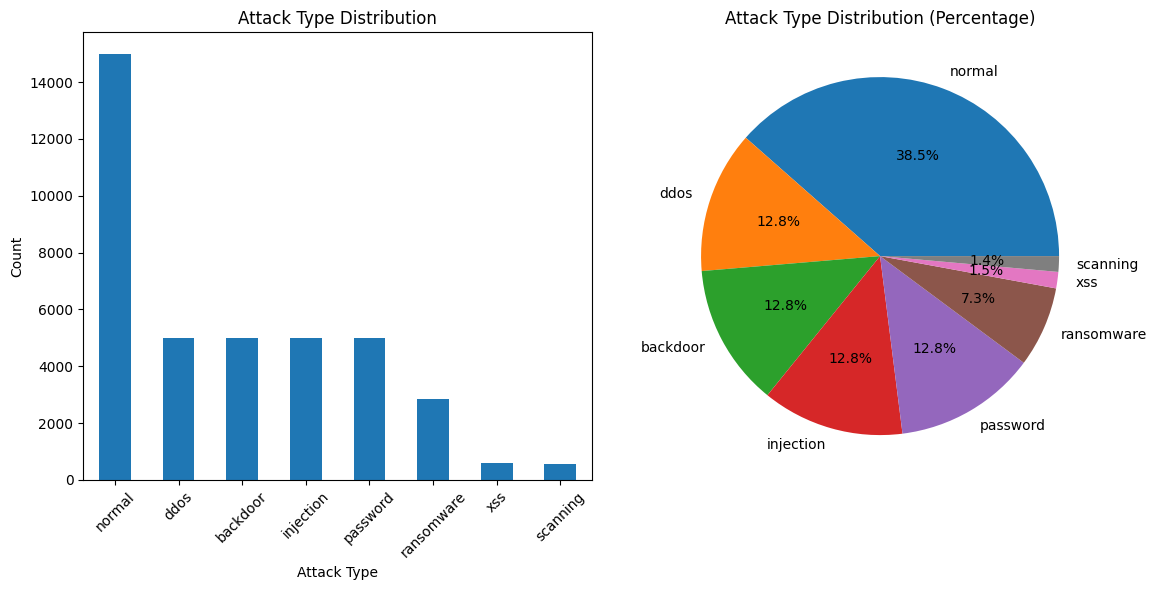

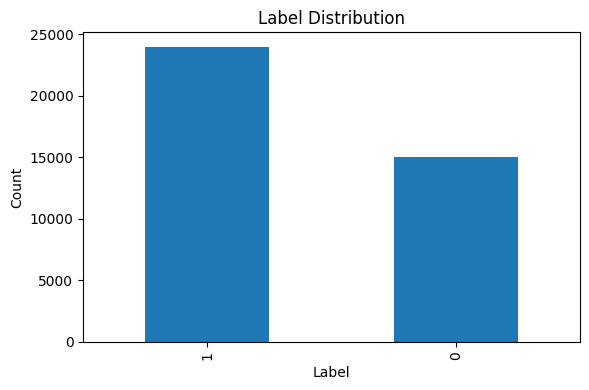

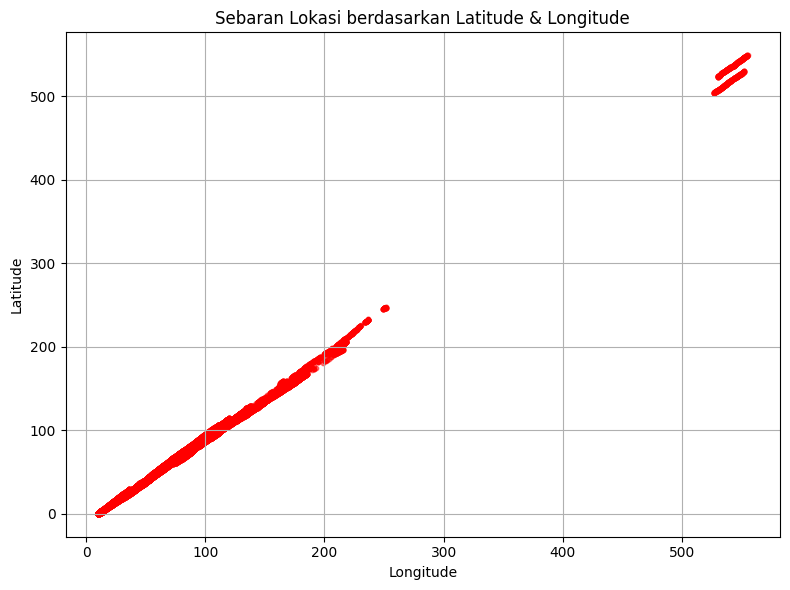

In [3]:
# =============================
# DATA EXPLORATION
# ================================

# Check data types
print("Data Types:")
print(df.dtypes)

print("\nLatitude stats:")
print(df['latitude'].describe())

print("\nLongitude stats:")
print(df['longitude'].describe())

# Check unique values in categorical columns
print(f"\nUnique attack types: {df['type'].unique()}")
print(f"Attack type distribution:")
attack_distribution = df['type'].value_counts()
print(attack_distribution)

print(f"\nLabel distribution:")
label_distribution = df['label'].value_counts()
print(label_distribution)

# Visualize attack type distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['type'].value_counts().plot(kind='bar', rot=45)
plt.title('Attack Type Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Attack Type Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'attack_type_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Visualize label distribution
plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'label_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df['longitude'], df['latitude'], 
            c='red', alpha=0.5, s=10)
plt.title('Sebaran Lokasi berdasarkan Latitude & Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'location_scatter.png'), dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# Implementasi Kalman Filter untuk sphone_signal
def apply_kalman_filter(signal_data):
    if hasattr(signal_data, 'values'):
        signal_array = signal_data.values
    else:
        signal_array = np.array(signal_data)
    observations = signal_array.reshape(-1, 1)
    kf = KalmanFilter(
        transition_matrices=np.array([[1, 1], [0, 1]]),
        observation_matrices=np.array([[1, 0]]),
        initial_state_mean=np.array([signal_array[0], 0]),
        initial_state_covariance=np.eye(2),
        observation_covariance=np.array([[1.0]]),
        transition_covariance=np.array([[0.1, 0], [0, 0.1]]),
        n_dim_state=2
    )
    kf_fitted = kf.em(observations, n_iter=10)
    state_means, _ = kf_fitted.smooth(observations)
    return state_means[:, 0]

In [5]:
df_filtered = df.copy()
df_filtered['latitude'] = apply_kalman_filter(df['latitude'])
df_filtered['longitude'] = apply_kalman_filter(df['longitude'])

In [6]:
# ================================
# FEATURE ENGINEERING
# ================================

print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

# Fungsi perhitungan jarak Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Radius bumi dalam meter
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(a**0.5, (1-a)**0.5)
    return R * c

# Fungsi perhitungan bearing
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = cos(lat2) * sin(dlon)
    y = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(dlon)
    bearing = atan2(x, y)
    bearing = degrees(bearing)
    return (bearing + 360) % 360

# Fungsi normalisasi sudut untuk direction change
def normalize_angle(diff):
    return (diff + 180) % 360 - 180

# Create a copy for preprocessing
df_processed = df_filtered.copy()

# Gabungkan kolom date dan time menjadi satu kolom
df_processed['datetime'] = pd.to_datetime(
    (df_processed['date'] + ' ' + df_processed['time']).str.strip(),
    format='%d-%b-%y %H:%M:%S',
    errors='coerce'
)
df_processed = df_processed.sort_values('datetime').reset_index(drop=True)
df_processed['group_id'] = df_processed['datetime'].dt.floor('T')  # per menit
# Extract time-based features
df_processed['hour'] = df_processed['datetime'].dt.hour
df_processed['minute'] = df_processed['datetime'].dt.minute
df_processed['second'] = df_processed['datetime'].dt.second
df_processed['day_of_week'] = df_processed['datetime'].dt.dayofweek
df_processed['is_weekend'] = (df_processed['day_of_week'] >= 5).astype(int)

# Create time-based cyclical features
df_processed['hour_sin'] = np.sin(2 * np.pi * df_processed['hour'] / 24)
df_processed['hour_cos'] = np.cos(2 * np.pi * df_processed['hour'] / 24)
df_processed['minute_sin'] = np.sin(2 * np.pi * df_processed['minute'] / 60)
df_processed['minute_cos'] = np.cos(2 * np.pi * df_processed['minute'] / 60)
df_processed['second_sin'] = np.cos(2 * np.pi * df_processed['second'] / 60)
df_processed['second_cos'] = np.cos(2 * np.pi * df_processed['second'] / 60)

df_processed['is_business_hour'] = ((df_processed['hour'] >= 9) & (df_processed['hour'] <= 17)).astype(int)
df_processed['is_night'] = ((df_processed['hour'] >= 22) | (df_processed['hour'] <= 6)).astype(int)
df_processed['is_rush_hour'] = (((df_processed['hour'] >= 7) & (df_processed['hour'] <= 9)) | 
                     ((df_processed['hour'] >= 17) & (df_processed['hour'] <= 19))).astype(int)

# 3. Fitur Geospatial
## Perubahan longitude
df_processed['delta_lon'] = df_processed['longitude'].diff()

## Bearing dan direction change
df_processed['prev_lat'] = df_processed['latitude'].shift(1)
df_processed['prev_lon'] = df_processed['longitude'].shift(1)

# Hitung bearing
df_processed['bearing'] = df_processed.apply(
    lambda row: calculate_bearing(
        row['prev_lat'], row['prev_lon'],
        row['latitude'], row['longitude']
    ) if not pd.isna(row['prev_lat']) else np.nan,
    axis=1
)

# Encoding bearing
df_processed['bearing_sin'] = np.sin(np.radians(df_processed['bearing']))
df_processed['bearing_cos'] = np.cos(np.radians(df_processed['bearing']))

# Hitung direction change
df_processed['prev_bearing'] = df_processed['bearing'].shift(1)
df_processed['bearing_diff'] = df_processed['bearing'] - df_processed['prev_bearing']
df_processed['normalized_diff'] = df_processed['bearing_diff'].apply(
    lambda x: normalize_angle(x) if not pd.isna(x) else np.nan
)
df_processed['direction_change'] = np.abs(df_processed['normalized_diff'])

# 4. Fitur Pergerakan
## Hitung selisih waktu
df_processed['time_diff'] = df_processed['datetime'].diff().dt.total_seconds()

## Hitung jarak Haversine
df_processed['distance_m_haversine'] = df_processed.apply(
    lambda row: haversine(
        row['prev_lat'], row['prev_lon'],
        row['latitude'], row['longitude']
    ) if not pd.isna(row['prev_lat']) else 0,
    axis=1
)

## Hitung kecepatan (m/s)
df_processed['speed_m_s'] = df_processed['distance_m_haversine'] / df_processed['time_diff']
df_processed['speed_m_s'] = df_processed['speed_m_s'].replace([np.inf, -np.inf], np.nan).fillna(0)

## Hitung percepatan
df_processed['prev_speed'] = df_processed['speed_m_s'].shift(1)
df_processed['acceleration'] = (df_processed['speed_m_s'] - df_processed['prev_speed']) / df_processed['time_diff']
df_processed['acceleration'] = df_processed['acceleration'].replace([np.inf, -np.inf], np.nan).fillna(0)

## Hitung jerk (turunan percepatan)
df_processed['prev_accel'] = df_processed['acceleration'].shift(1)
df_processed['jerk'] = (df_processed['acceleration'] - df_processed['prev_accel']) / df_processed['time_diff']
df_processed['jerk'] = df_processed['jerk'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 5. Fitur Sekuensial
## Rolling features (window=5)
df_processed['speed_rolling_mean_5'] = df_processed['speed_m_s'].rolling(window=5, min_periods=1).mean()
df_processed['speed_rolling_std_5'] = df_processed['speed_m_s'].rolling(window=5, min_periods=1).std().fillna(0)
df_processed['distance_rolling_mean_5'] = df_processed['distance_m_haversine'].rolling(window=5, min_periods=1).mean()

## Lag features
df_processed['speed_lag_1'] = df_processed['speed_m_s'].shift(1).fillna(0)
df_processed['speed_lag_2'] = df_processed['speed_m_s'].shift(2).fillna(0)

## Jarak kumulatif
df_processed['cumulative_distance'] = df_processed['distance_m_haversine'].cumsum()

# 6. Fitur Perilaku
## Z-score
for col in ['speed_m_s', 'distance_m_haversine', 'time_diff']:
    mean_val = df_processed[col].mean()
    std_val = df_processed[col].std()
    df_processed[f'{col}_zscore'] = (df_processed[col] - mean_val) / std_val if std_val != 0 else 0

## Deteksi anomali
df_processed['is_speed_anomaly'] = (np.abs(df_processed['speed_m_s_zscore']) > 3).astype(int)
df_processed['is_distance_anomaly'] = (np.abs(df_processed['distance_m_haversine_zscore']) > 3).astype(int)
df_processed['is_time_anomaly'] = (np.abs(df_processed['time_diff_zscore']) > 3).astype(int)

## Encode pola pergerakan
speed_bins = [-np.inf, 0.1, 1.0, 5.0, np.inf]
df_processed['movement_pattern_encoded'] = pd.cut(
    df_processed['speed_m_s'], 
    bins=speed_bins, 
    labels=[0, 1, 2, 3]
).cat.codes

# 7. Membersihkan kolom sementara
cols_to_drop = [
    'date', 'time', 'prev_lat', 'prev_lon', 'prev_bearing',
    'bearing_diff', 'normalized_diff', 'prev_speed', 'prev_accel',
    'hour', 'minute', 'second', 'day_of_week'
]
df_processed.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print("Feature engineering completed!")
print(df.head())
print("\nKolom yang dihasilkan:", df_processed.columns.tolist())
print(df_processed.head())


FEATURE ENGINEERING
Feature engineering completed!
        date        time    latitude   longitude  label  type
0  25-Apr-19   18:31:39   116.521704  132.162504      1  ddos
1  25-Apr-19   18:31:41   121.742933  135.072500      1  ddos
2  25-Apr-19   18:31:46   121.795929  135.110198      1  ddos
3  25-Apr-19   18:31:49   116.611216  132.224555      1  ddos
4  25-Apr-19   18:31:51   121.841526  135.151362      1  ddos

Kolom yang dihasilkan: ['latitude', 'longitude', 'label', 'type', 'datetime', 'group_id', 'is_weekend', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos', 'is_business_hour', 'is_night', 'is_rush_hour', 'delta_lon', 'bearing', 'bearing_sin', 'bearing_cos', 'direction_change', 'time_diff', 'distance_m_haversine', 'speed_m_s', 'acceleration', 'jerk', 'speed_rolling_mean_5', 'speed_rolling_std_5', 'distance_rolling_mean_5', 'speed_lag_1', 'speed_lag_2', 'cumulative_distance', 'speed_m_s_zscore', 'distance_m_haversine_zscore', 'time_diff_zscore

In [7]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38960 entries, 0 to 38959
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   latitude                     38960 non-null  float64       
 1   longitude                    38960 non-null  float64       
 2   label                        38960 non-null  int64         
 3   type                         38960 non-null  object        
 4   datetime                     38960 non-null  datetime64[ns]
 5   group_id                     38960 non-null  datetime64[ns]
 6   is_weekend                   38960 non-null  int32         
 7   hour_sin                     38960 non-null  float64       
 8   hour_cos                     38960 non-null  float64       
 9   minute_sin                   38960 non-null  float64       
 10  minute_cos                   38960 non-null  float64       
 11  second_sin                   38960 non-nu


MISSING VALUES ANALYSIS
Missing values summary:
                  Missing Count  Missing Percentage
delta_lon                     1            0.002567
bearing                       1            0.002567
bearing_sin                   1            0.002567
bearing_cos                   1            0.002567
direction_change              2            0.005133
time_diff                     1            0.002567
time_diff_zscore              1            0.002567


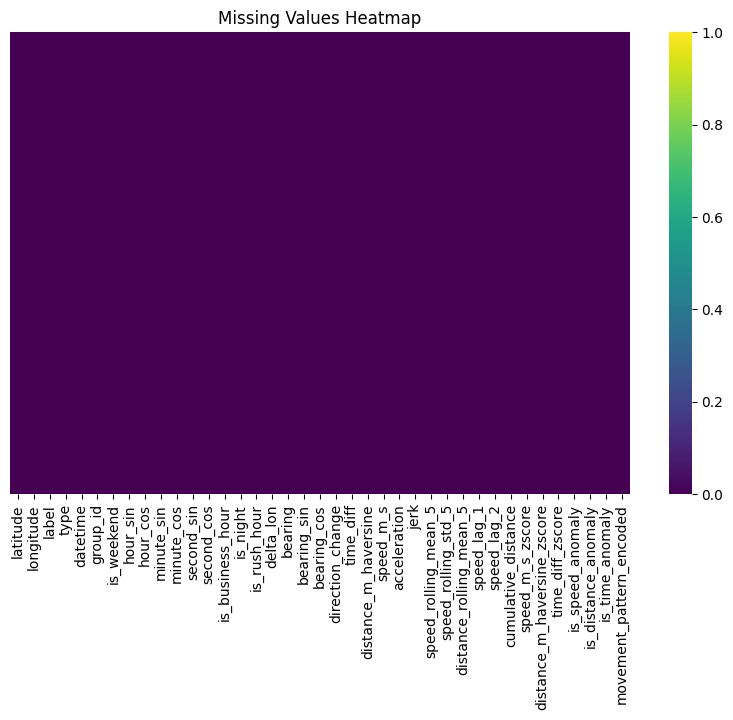

In [8]:
# ================================
# IDENTIFYING MISSING VALUES
# ================================

print("\n" + "="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)

# Check for missing values
missing_values = df_processed.isnull().sum()
missing_percentage = (missing_values / len(df_processed)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

print("Missing values summary:")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualize missing values if any
if missing_values.sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_processed.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.savefig(os.path.join(viz_dir, 'missing_values_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No missing values found in the dataset!")

In [9]:
print(df_processed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38960 entries, 0 to 38959
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   latitude                     38960 non-null  float64       
 1   longitude                    38960 non-null  float64       
 2   label                        38960 non-null  int64         
 3   type                         38960 non-null  object        
 4   datetime                     38960 non-null  datetime64[ns]
 5   group_id                     38960 non-null  datetime64[ns]
 6   is_weekend                   38960 non-null  int32         
 7   hour_sin                     38960 non-null  float64       
 8   hour_cos                     38960 non-null  float64       
 9   minute_sin                   38960 non-null  float64       
 10  minute_cos                   38960 non-null  float64       
 11  second_sin                   38960 non-nu

In [12]:
# ----- STEP 1: Siapkan data -----
X_all = df_processed.copy()
X_all.drop(['datetime', 'group_id', 'type', 'label'], axis=1, inplace=True)
y_all = df_processed['type'].copy()
groups_all = df_processed['group_id']

# ----- STEP 2: Fungsi bantu untuk menghitung distribusi label -----
def get_label_distribution(y):
    dist = y.value_counts(normalize=True).sort_index()
    return dist

# ----- STEP 3: Cari split dengan distribusi label terbaik -----
best_split = None
lowest_diff_score = float('inf')

n_trials = 10  # jumlah percobaan

for trial in range(n_trials):
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=trial)

    for train_idx, temp_idx in sgkf.split(X_all, y_all, groups=groups_all):
        # Split awal: Train (70%), Temp (30%)
        X_train = X_all.iloc[train_idx]
        y_train = y_all.iloc[train_idx]
        groups_train = groups_all.iloc[train_idx]

        X_temp = X_all.iloc[temp_idx]
        y_temp = y_all.iloc[temp_idx]
        groups_temp = groups_all.iloc[temp_idx]

        # Dari Temp, split lagi jadi val/test (masing-masing 15%)
        sgkf_inner = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=trial)

        for val_idx, test_idx in sgkf_inner.split(X_temp, y_temp, groups=groups_temp):
            X_val = X_temp.iloc[val_idx]
            y_val = y_temp.iloc[val_idx]

            X_test = X_temp.iloc[test_idx]
            y_test = y_temp.iloc[test_idx]

            # Hitung distribusi label dan perbedaannya
            dist_train = get_label_distribution(y_train)
            dist_val = get_label_distribution(y_val)
            dist_test = get_label_distribution(y_test)

            # Gabungkan dan hitung error
            labels_all = sorted(list(set(y_all)))
            dist_train = dist_train.reindex(labels_all, fill_value=0)
            dist_val = dist_val.reindex(labels_all, fill_value=0)
            dist_test = dist_test.reindex(labels_all, fill_value=0)

            diff_score = mean_squared_error(dist_train, dist_val) + mean_squared_error(dist_train, dist_test)

            if diff_score < lowest_diff_score:
                lowest_diff_score = diff_score
                best_split = {
                    "X_train": X_train, "y_train": y_train,
                    "X_val": X_val, "y_val": y_val,
                    "X_test": X_test, "y_test": y_test
                }

            break  # hanya ambil satu val/test split dari 2-fold
    print(f"Percobaan {trial+1} selesai. Skor distribusi: {lowest_diff_score:.5f}")

# ----- STEP 4: Ambil hasil split terbaik -----
X_train_best = best_split["X_train"]
y_train_best = best_split["y_train"]
X_val_best = best_split["X_val"]
y_val_best = best_split["y_val"]
X_test_best = best_split["X_test"]
y_test_best = best_split["y_test"]

# ----- STEP 5: Tampilkan distribusi label terbaik -----
print("\nDistribusi label terbaik:")
for name, y_part in zip(['Train', 'Val', 'Test'], [y_train_best, y_val_best, y_test_best]):
    print(f"\n{name}:\n", y_part.value_counts(normalize=True).sort_index().apply(lambda x: f"{x:.2%}"))

Percobaan 1 selesai. Skor distribusi: 0.00981
Percobaan 2 selesai. Skor distribusi: 0.00655
Percobaan 3 selesai. Skor distribusi: 0.00655
Percobaan 4 selesai. Skor distribusi: 0.00655
Percobaan 5 selesai. Skor distribusi: 0.00167
Percobaan 6 selesai. Skor distribusi: 0.00167
Percobaan 7 selesai. Skor distribusi: 0.00167
Percobaan 8 selesai. Skor distribusi: 0.00167
Percobaan 9 selesai. Skor distribusi: 0.00167
Percobaan 10 selesai. Skor distribusi: 0.00050

Distribusi label terbaik:

Train:
 type
backdoor      12.56%
ddos          12.92%
injection     13.00%
normal        38.35%
password      12.92%
ransomware     7.34%
scanning       1.43%
xss            1.49%
Name: proportion, dtype: object

Val:
 type
backdoor      13.24%
ddos          12.50%
injection     11.77%
normal        41.86%
password      13.42%
ransomware     4.67%
scanning       1.58%
xss            0.96%
Name: proportion, dtype: object

Test:
 type
backdoor      14.56%
ddos          12.53%
injection     12.74%
normal    

In [13]:
print("Train class distribution:\n", y_train_best.value_counts(normalize=True))
print("Validation class distribution:\n", y_val_best.value_counts(normalize=True))
print("Test class distribution:\n", y_test_best.value_counts(normalize=True))

Train class distribution:
 type
normal        0.383454
injection     0.129965
ddos          0.129184
password      0.129184
backdoor      0.125606
ransomware    0.073392
xss           0.014932
scanning      0.014282
Name: proportion, dtype: float64
Validation class distribution:
 type
normal        0.418594
password      0.134188
backdoor      0.132356
ddos          0.125029
injection     0.117701
ransomware    0.046714
scanning      0.015800
xss           0.009618
Name: proportion, dtype: float64
Test class distribution:
 type
normal        0.359367
backdoor      0.145563
injection     0.127400
ddos          0.125324
password      0.114946
ransomware    0.096783
xss           0.019720
scanning      0.010898
Name: proportion, dtype: float64


In [14]:
def show_label_distribution(y_train, y_val, y_test, label_name='type'):
    # Buat dataframe dari label
    dist_df = pd.DataFrame({
        'train': y_train.value_counts(normalize=False),
        'val': y_val.value_counts(normalize=False),
        'test': y_test.value_counts(normalize=False)
    }).fillna(0).astype(int)

    dist_df_percent = pd.DataFrame({
        'train': y_train.value_counts(normalize=True) * 100,
        'val': y_val.value_counts(normalize=True) * 100,
        'test': y_test.value_counts(normalize=True) * 100
    }).fillna(0).round(2)

    # Tampilkan distribusi dalam bentuk tabel
    print("Distribusi Label (Jumlah):\n", dist_df)
    print("\nDistribusi Label (Persentase):\n", dist_df_percent)

    # Plot jumlah label
    dist_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
    plt.title(f'Distribusi Label {label_name.upper()} - Jumlah')
    plt.xlabel('Label')
    plt.ylabel('Jumlah')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Plot persentase label
    dist_df_percent.plot(kind='bar', figsize=(10, 6), colormap='Set2')
    plt.title(f'Distribusi Label {label_name.upper()} - Persentase')
    plt.xlabel('Label')
    plt.ylabel('Persentase (%)')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

Distribusi Label (Jumlah):
             train   val  test
type                         
backdoor     3861   578   561
ddos         3971   546   483
injection    3995   514   491
normal      11787  1828  1385
password     3971   586   443
ransomware   2256   204   373
scanning      439    69    42
xss           459    42    76

Distribusi Label (Persentase):
             train    val   test
type                           
backdoor    12.56  13.24  14.56
ddos        12.92  12.50  12.53
injection   13.00  11.77  12.74
normal      38.35  41.86  35.94
password    12.92  13.42  11.49
ransomware   7.34   4.67   9.68
scanning     1.43   1.58   1.09
xss          1.49   0.96   1.97


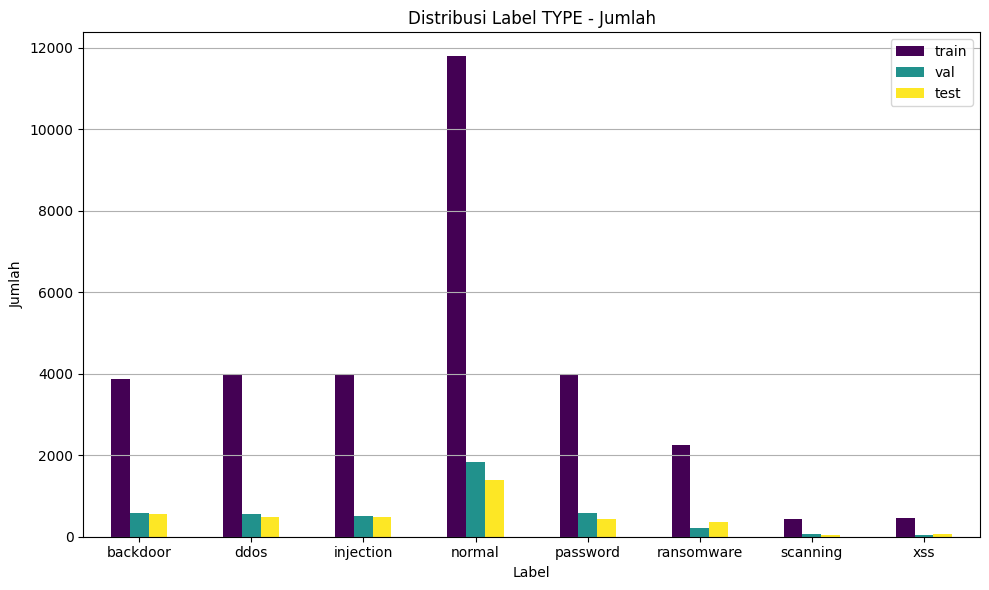

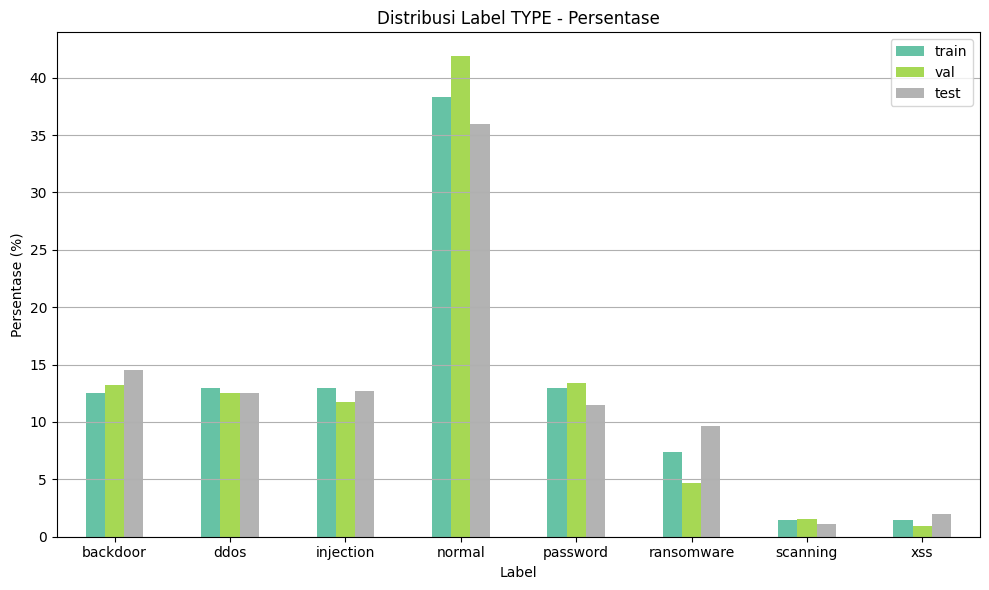

In [15]:
show_label_distribution(y_train_best, y_val_best, y_test_best, label_name='type')

In [16]:
# ================================
# SIMPLE IMPUTER AND MINMAX SCALER
# ================================

print("\n" + "="*50)
print("DATA PREPROCESSING - IMPUTATION AND SCALING")
print("="*50)

# Handle any remaining missing values with SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_imputed_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_imputed_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

print(f"Features shape train after imputation: {X_imputed_train.shape}")
print(f"Features shape val after imputation: {X_imputed_val.shape}")
print(f"Features shape test after imputation: {X_imputed_test.shape}")

# Apply MinMax Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_best)
X_val_scaled = scaler.transform(X_val_best)
X_test_scaled = scaler.transform(X_test_best)

print("Data scaling completed!")
print(f"Scaled features train shape: {X_train_scaled.shape}")
print(f"Scaled features val shape: {X_val_scaled.shape}")
print(f"Scaled features test shape: {X_test_scaled.shape}")

# Save preprocessors
with open(os.path.join(artifacts_dir, 'imputer.pkl'), 'wb') as f:
    pickle.dump(imputer, f)

with open(os.path.join(artifacts_dir, 'minmax.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

print(f"Imputer saved to {artifacts_dir}/imputer.pkl")
print(f"Scaler saved to {artifacts_dir}/minmax.pkl")

# Encode target labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_best)
y_val_encoded = le.transform(y_val_best)
y_test_encoded = le.transform(y_test_best)

# Save target label encoder
with open(os.path.join(artifacts_dir, 'label_encoder_target.pkl'), 'wb') as f:
    pickle.dump(le, f)

print(f"Target classes: {le.classes_}")
print(f"Target train shape: {y_train_encoded.shape}")
print(f"Target val shape: {y_val_encoded.shape}")
print(f"Target test shape: {y_test_encoded.shape}")
print(f"Target label encoder saved to {artifacts_dir}/label_encoder_target.pkl")


DATA PREPROCESSING - IMPUTATION AND SCALING
Features shape train after imputation: (27384, 35)
Features shape val after imputation: (4414, 35)
Features shape test after imputation: (7162, 35)
Data scaling completed!
Scaled features train shape: (30739, 35)
Scaled features val shape: (4367, 35)
Scaled features test shape: (3854, 35)
Imputer saved to artifacts/imputer.pkl
Scaler saved to artifacts/minmax.pkl
Target classes: ['backdoor' 'ddos' 'injection' 'normal' 'password' 'ransomware' 'scanning'
 'xss']
Target train shape: (30739,)
Target val shape: (4367,)
Target test shape: (3854,)
Target label encoder saved to artifacts/label_encoder_target.pkl


In [17]:
y_train_cat = to_categorical(y_train_encoded)
y_val_cat = to_categorical(y_val_encoded)
y_test_cat = to_categorical(y_test_encoded)

In [18]:
print(X_train_scaled.shape)
print('\n',X_train_scaled[:5])
print('\n',X_val_scaled.shape)
print('\n',X_val_scaled[:5])
print('\n',X_test_scaled.shape)
print('\n',X_test_scaled[:5])
print('\n',y_train_encoded.shape)
print('\n',y_train_encoded[:10])
print('\n',y_val_encoded.shape)
print('\n',y_val_encoded[:10])
print('\n',y_test_encoded.shape)
print('\n',y_test_encoded[:10])
print('\n',y_train_cat.shape)
print('\n',y_train_cat[:10])
print('\n',y_val_cat.shape)
print('\n',y_val_cat[:10])
print('\n',y_test_cat.shape)
print('\n',y_test_cat[:10])

(30739, 35)

 [[2.47595517e-02 2.49289969e-02 1.00000000e+00 5.00000000e-01
  0.00000000e+00 1.65434697e-01 1.28427587e-01 1.00000000e+00
  1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  4.89559618e-01 6.25207416e-01 1.45981777e-01 1.46911745e-01
  4.01122617e-04 5.24143628e-07 2.84849494e-02 8.55700860e-02
  3.67972519e-01 5.06308597e-01 2.04970390e-01 2.38209703e-01
  8.04107267e-02 0.00000000e+00 1.61843422e-01 0.00000000e+00
  8.55700860e-02 2.84849494e-02 5.24143628e-07 1.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [2.33551485e-02 2.35220767e-02 1.00000000e+00 5.00000000e-01
  0.00000000e+00 1.65434697e-01 1.28427587e-01 1.00000000e+00
  1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  4.92277744e-01 6.25608125e-01 1.45093931e-01 1.47804172e-01
  8.01181991e-04 0.00000000e+00 1.88416676e-02 0.00000000e+00
  2.96040357e-01 4.50120708e-01 9.95524266e-02 1.54980639e-01
  6.07236362e-02 8.55700860e-02 0.00000000e+00 1.05682383e-04
  0.0000

In [19]:
# ================================
# SELEKSI FITUR GA
# ================================

# ===========================
# === PARAMETER DAN INPUT ===
# ===========================
POP_SIZE = 20
N_GENERATIONS = 10
MUTATION_RATE = 0.1
TOURNAMENT_SIZE = 3
FEATURE_COUNT = X_train_scaled.shape[1]
N_CLASSES = y_train_cat.shape[1]

# =============================
# === MODEL LSTM SEDERHANA ===
# =============================
def create_lstm_model(input_shape, n_classes):
    model = Sequential([
        LSTM(32, input_shape=input_shape),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# =============================
# === FUNGSI FITNESS GA ===
# =============================
def fitness(individual):
    if sum(individual) == 0:
        return 0.0,

    selected_features = [i for i, bit in enumerate(individual) if bit == 1]
    
    # Ambil subset fitur berdasarkan indeks aktif
    X_train_sub = X_train_scaled[:, selected_features]
    X_val_sub   = X_val_scaled[:, selected_features]

    # Reshape untuk LSTM: (samples, timesteps=1, features)
    X_train_sub = X_train_sub.reshape((X_train_sub.shape[0], 1, X_train_sub.shape[1]))
    X_val_sub   = X_val_sub.reshape((X_val_sub.shape[0], 1, X_val_sub.shape[1]))

    # Buat dan latih model LSTM
    model = create_lstm_model(input_shape=(1, len(selected_features)), n_classes=N_CLASSES)
    model.fit(X_train_sub, y_train_cat, epochs=3, batch_size=64, verbose=0)

    # Evaluasi akurasi
    y_pred = np.argmax(model.predict(X_val_sub, verbose=0), axis=1)
    y_true = np.argmax(y_val_cat, axis=1)
    acc = accuracy_score(y_true, y_pred)

    return acc,

# =============================
# === TOOLS UNTUK GA ===
# =============================
def init_population():
    return [np.random.randint(0, 2, FEATURE_COUNT).tolist() for _ in range(POP_SIZE)]

def tournament_selection(pop, fitnesses):
    selected = random.sample(list(zip(pop, fitnesses)), TOURNAMENT_SIZE)
    selected = sorted(selected, key=lambda x: x[1][0], reverse=True)
    return selected[0][0]

def crossover(parent1, parent2):
    point = random.randint(1, FEATURE_COUNT - 1)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

def mutate(individual):
    for i in range(FEATURE_COUNT):
        if random.random() < MUTATION_RATE:
            individual[i] = 1 - individual[i]

# =============================
# === MAIN LOOP GA ===
# =============================
population = init_population()
fitnesses = [fitness(ind) for ind in population]

for gen in range(N_GENERATIONS):
    print(f'\nGeneration {gen + 1}/{N_GENERATIONS}')
    
    accs = [fit[0] for fit in fitnesses]
    print(f' Best fitness: {max(accs):.4f} | Avg fitness: {np.mean(accs):.4f}')

    new_population = []
    while len(new_population) < POP_SIZE:
        parent1 = tournament_selection(population, fitnesses)
        parent2 = tournament_selection(population, fitnesses)
        child1, child2 = crossover(parent1, parent2)
        mutate(child1)
        mutate(child2)
        new_population.extend([child1, child2])

    # Evaluasi populasi baru
    population = new_population[:POP_SIZE]
    fitnesses = [fitness(ind) for ind in population]

# =============================
# === HASIL AKHIR SELEKSI ===
# =============================
accs = [fit[0] for fit in fitnesses]
best_idx = np.argmax(accs)
best_individual = population[best_idx]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]

print("\n=== HASIL SELEKSI FITUR GA ===")
print("Indeks Fitur Terpilih:", selected_features)
print("Jumlah Fitur Terpilih:", len(selected_features))
print("Best Fitness (Accuracy): {:.4f}".format(accs[best_idx]))


Generation 1/10
 Best fitness: 0.9766 | Avg fitness: 0.8186

Generation 2/10
 Best fitness: 0.9860 | Avg fitness: 0.8427

Generation 3/10
 Best fitness: 0.9663 | Avg fitness: 0.9156

Generation 4/10
 Best fitness: 0.9730 | Avg fitness: 0.9289

Generation 5/10
 Best fitness: 0.9750 | Avg fitness: 0.9172

Generation 6/10
 Best fitness: 0.9707 | Avg fitness: 0.9489

Generation 7/10
 Best fitness: 0.9746 | Avg fitness: 0.9380

Generation 8/10
 Best fitness: 0.9824 | Avg fitness: 0.9495

Generation 9/10
 Best fitness: 0.9817 | Avg fitness: 0.9392

Generation 10/10
 Best fitness: 0.9801 | Avg fitness: 0.9525

=== HASIL SELEKSI FITUR GA ===
Indeks Fitur Terpilih: [1, 2, 3, 4, 8, 10, 13, 14, 15, 18, 21, 22, 25, 27, 29, 30, 31, 32, 33, 34]
Jumlah Fitur Terpilih: 20
Best Fitness (Accuracy): 0.9817


In [ ]:
feature_names = X_all.columns.tolist()

selected_feature_names = [feature_names[i] for i in selected_features]
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: ['longitude', 'is_weekend', 'hour_sin', 'hour_cos', 'second_cos', 'is_night', 'bearing', 'bearing_sin', 'bearing_cos', 'distance_m_haversine', 'jerk', 'speed_rolling_mean_5', 'speed_lag_1', 'cumulative_distance', 'distance_m_haversine_zscore', 'time_diff_zscore', 'is_speed_anomaly', 'is_distance_anomaly', 'is_time_anomaly', 'movement_pattern_encoded']


In [21]:
X_train_selected = pd.DataFrame(X_train_scaled[:, selected_features], columns=[feature_names[i] for i in selected_features])
print(X_train_selected.shape)
print(X_train_selected.info())
print(X_train_selected.head())

(30739, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30739 entries, 0 to 30738
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   longitude                    30739 non-null  float64
 1   is_weekend                   30739 non-null  float64
 2   hour_sin                     30739 non-null  float64
 3   hour_cos                     30739 non-null  float64
 4   second_cos                   30739 non-null  float64
 5   is_night                     30739 non-null  float64
 6   bearing                      30739 non-null  float64
 7   bearing_sin                  30739 non-null  float64
 8   bearing_cos                  30739 non-null  float64
 9   distance_m_haversine         30739 non-null  float64
 10  jerk                         30739 non-null  float64
 11  speed_rolling_mean_5         30739 non-null  float64
 12  speed_lag_1                  30739 non-null  float64
 13  cumu

In [22]:
X_val_selected = pd.DataFrame(X_val_scaled[:, selected_features], columns=[feature_names[i] for i in selected_features])
print(X_val_selected.shape)
print(X_val_selected.info())

(4367, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4367 entries, 0 to 4366
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   longitude                    4367 non-null   float64
 1   is_weekend                   4367 non-null   float64
 2   hour_sin                     4367 non-null   float64
 3   hour_cos                     4367 non-null   float64
 4   second_cos                   4367 non-null   float64
 5   is_night                     4367 non-null   float64
 6   bearing                      4366 non-null   float64
 7   bearing_sin                  4366 non-null   float64
 8   bearing_cos                  4366 non-null   float64
 9   distance_m_haversine         4367 non-null   float64
 10  jerk                         4367 non-null   float64
 11  speed_rolling_mean_5         4367 non-null   float64
 12  speed_lag_1                  4367 non-null   float64
 13  cumulat

In [23]:
X_test_selected = pd.DataFrame(X_test_scaled[:, selected_features], columns=[feature_names[i] for i in selected_features])
print(X_test_selected.shape)
print(X_test_selected.info())

(3854, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3854 entries, 0 to 3853
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   longitude                    3854 non-null   float64
 1   is_weekend                   3854 non-null   float64
 2   hour_sin                     3854 non-null   float64
 3   hour_cos                     3854 non-null   float64
 4   second_cos                   3854 non-null   float64
 5   is_night                     3854 non-null   float64
 6   bearing                      3854 non-null   float64
 7   bearing_sin                  3854 non-null   float64
 8   bearing_cos                  3854 non-null   float64
 9   distance_m_haversine         3854 non-null   float64
 10  jerk                         3854 non-null   float64
 11  speed_rolling_mean_5         3854 non-null   float64
 12  speed_lag_1                  3854 non-null   float64
 13  cumulat


CORRELATION ANALYSIS


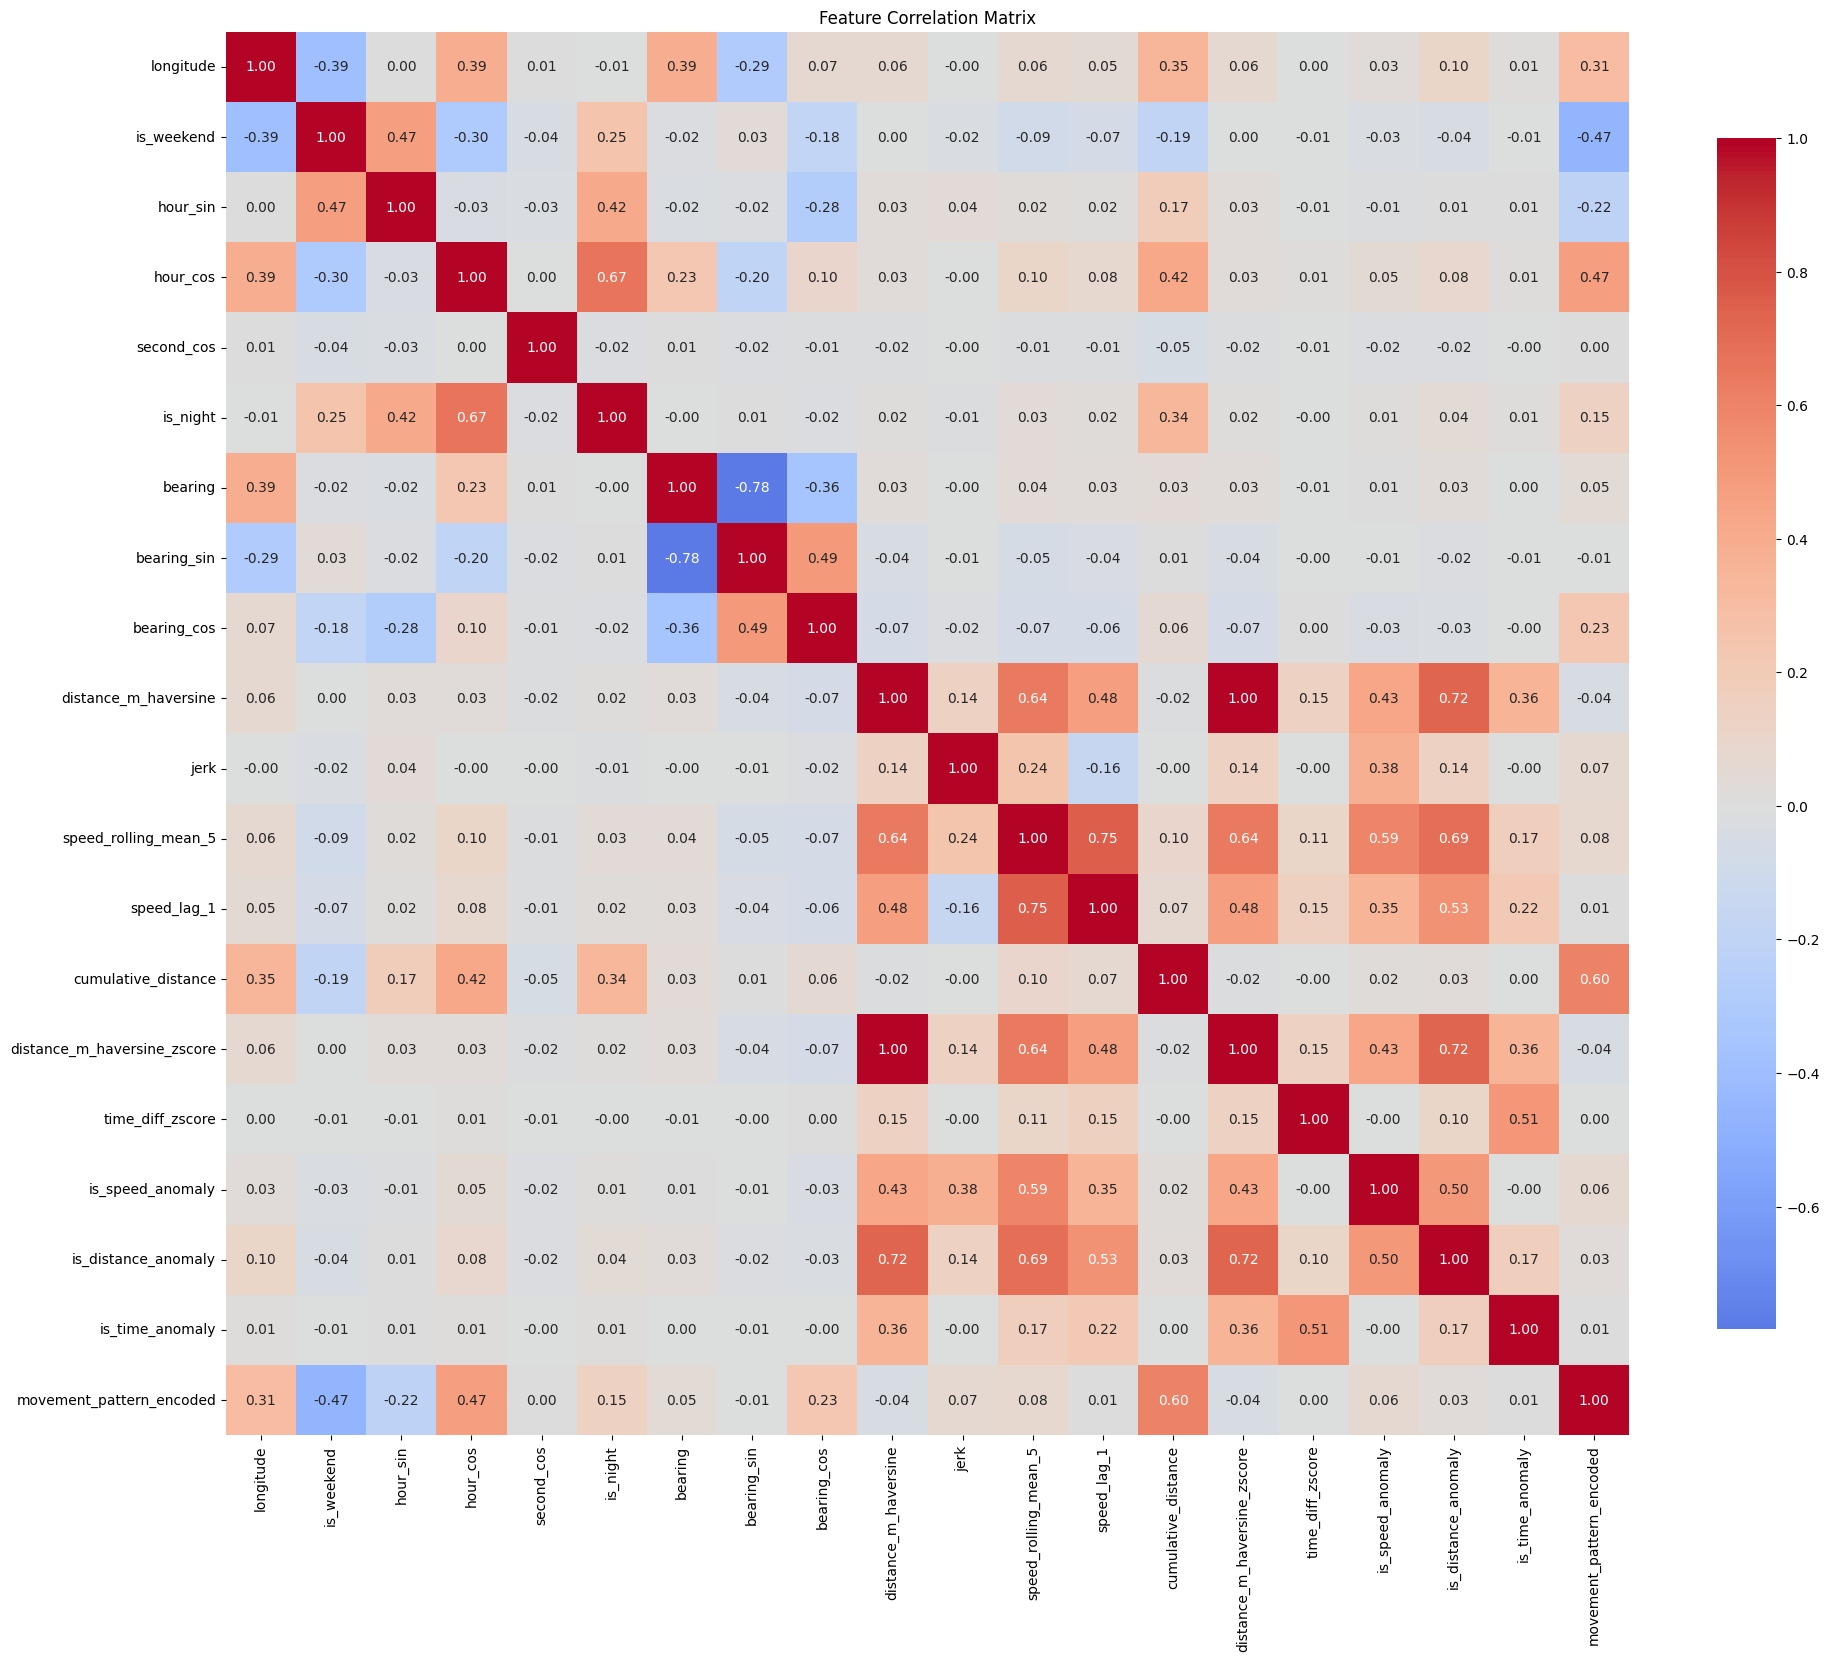

In [24]:
# ================================
# CORRELATION ANALYSIS
# ================================

print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Calculate correlation matrix
correlation_matrix = X_train_selected.corr()

# Visualize correlation matrix
plt.figure(figsize=(20, 17))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'correlation_matrix.png'), dpi=600, bbox_inches='tight')
plt.show()
plt.close()

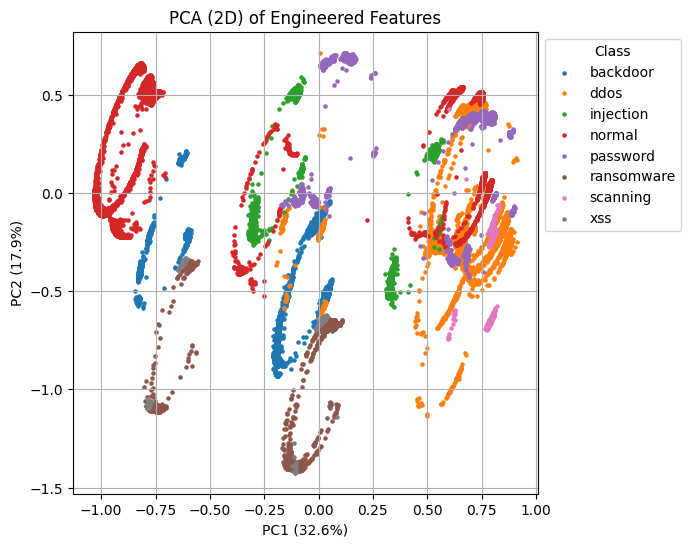

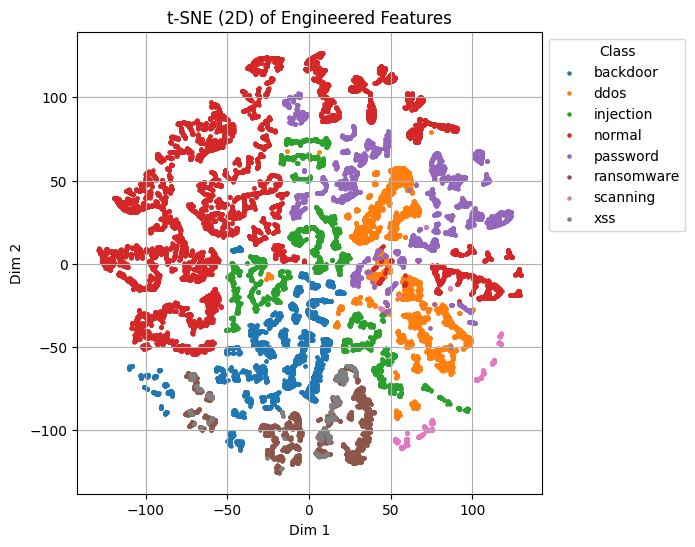

In [25]:
# PCA 2 Dimensi
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_selected)

plt.figure(figsize=(6,6))
for cls in np.unique(y_train_best):
    idx = y_train_best == cls
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('PCA (2D) of Engineered Features')
plt.xlabel('PC1 (%.1f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 (%.1f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'PCA_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

# t-SNE → 2 dimensi (lebih lambat)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_train_selected)  # pada seluruh dataset atau subset

plt.figure(figsize=(6,6))
for cls in np.unique(y_train_best):
    idx = y_train_best == cls
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('t-SNE (2D) of Engineered Features')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'tSNE_2D_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

In [26]:
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_train_selected)

# Buat DataFrame untuk Plotly
df_tsne = pd.DataFrame({
    'Dim1': X_tsne_3d[:, 0],
    'Dim2': X_tsne_3d[:, 1],
    'Dim3': X_tsne_3d[:, 2],
    'Class': y_train_best.astype(str)
})

# Plot interaktif 3D
fig = px.scatter_3d(
    df_tsne,
    x='Dim1', y='Dim2', z='Dim3',
    color='Class',
    opacity=0.7,
    title='t-SNE (3D) of Engineered Features',
    width=900, height=700
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene = dict(
        xaxis_title='Dim 1',
        yaxis_title='Dim 2',
        zaxis_title='Dim 3'
    ),
    legend_title='Class'
)

# Simpan file HTML ke folder viz_dir
html_path = os.path.join(viz_dir, 'tsne_3d.html')
fig.write_html(html_path)

print(f"File HTML disimpan di: {html_path}")

# PCA ke dalam 3 dimensi
pca = PCA(n_components=3, random_state=42)
X_pca_3d = pca.fit_transform(X_train_selected)

# Buat DataFrame dari hasil PCA dan label
df_pca = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca['label'] = y_train_best

# Visualisasi interaktif 3D menggunakan Plotly
fig = px.scatter_3d(
    df_pca, x='PC1', y='PC2', z='PC3',
    color='label',
    title='PCA (3D) of Engineered Features',
    labels={'label': 'Class'},
    opacity=0.7,
    width=800,
    height=600
)

# Simpan hasil visualisasi ke file HTML
output_html_path = os.path.join(viz_dir, 'PCA_3D.html')
fig.write_html(output_html_path)

File HTML disimpan di: visualization\tsne_3d.html


In [27]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_train_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_train_selected, y_train_cat), f)
    
# Simpan ke file CSV
df_final = pd.DataFrame(X_train_selected)
df_final['type'] = np.array(y_train_encoded)

csv_path = os.path.join(artifacts_dir, 'data_train_preprocessing.csv')
df_final.to_csv(csv_path, index=False)

In [28]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_val_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_val_selected, y_val_cat), f)
    
# Simpan ke file CSV
df_final = pd.DataFrame(X_val_selected)
df_final['type'] = np.array(y_val_encoded)

csv_path = os.path.join(artifacts_dir, 'data_val_preprocessing.csv')
df_final.to_csv(csv_path, index=False)

In [29]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_test_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_test_selected, y_test_cat), f)
    
# Simpan ke file CSV
df_final = pd.DataFrame(X_test_selected)
df_final['type'] = np.array(y_test_encoded)

csv_path = os.path.join(artifacts_dir, 'data_test_preprocessing.csv')
df_final.to_csv(csv_path, index=False)